

### Conv/LSTM Equations with Markdown:

1. **Input Gate** (\(i_t\)):
   $$ i_t = \sigma(W_{xi} \ast x_t + W_{hi} \ast h_{t-1} + W_{ci} \circ C_{t-1} + b_i) $$
   Decides what new information is added to the cell state, with convolution $\ast$ applied to inputs and the previous hidden state, and an element-wise multiplication $\circ$ with the previous cell state.

2. **Forget Gate** (\(f_t\)):
   $$ f_t = \sigma(W_{xf} \ast x_t + W_{hf} \ast h_{t-1} + W_{cf} \circ C_{t-1} + b_f) $$
   Decides what information is discarded from the cell state, utilizing the same convolutional and element-wise operations to weigh the inputs, previous hidden state, and previous cell state.

3. **Cell State** (\(C_t\)):
   $$ C_t = f_t \circ C_{t-1} + i_t \circ \tanh(W_{xc} \ast x_t + W_{hc} \ast h_{t-1} + b_c) $$
   Updates the cell state by forgetting selected past information and adding new candidate values, modulated by the input and forget gates' outputs and processed through convolutional layers.

4. **Output Gate** (\(o_t\)):
   $$ o_t = \sigma(W_{xo} \ast x_t + W_{ho} \ast h_{t-1} + W_{co} \circ C_t + b_o) $$
   Decides the next hidden state by filtering the cell state's content, with the convolution applied to inputs and the previous hidden state, and element-wise multiplication with the current cell state.

5. **Hidden State** (\(h_t\)):
   $$ h_t = o_t \circ \tanh(C_t) $$
   The final hidden state output for the current time step, combining the output gate's decision with the activated cell state to produce the next hidden state that carries both spatial and temporal information.





In [2]:
!wget https://raw.githubusercontent.com/cbtn-data-science-ml/tensorflow-professional-developer/main/model_utils.py

--2024-11-16 17:25:23--  https://raw.githubusercontent.com/cbtn-data-science-ml/tensorflow-professional-developer/main/model_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2305 (2.3K) [text/plain]
Saving to: ‘model_utils.py’

model_utils.py      100%[===================>]   2.25K  --.-KB/s    in 0s      

2024-11-16 17:25:23 (39.4 MB/s) - ‘model_utils.py’ saved [2305/2305]



In [4]:
from model_utils import plot_loss_and_accuracy, early_stopping_callback, model_checkpoint_callback

In [5]:
# Clone repo
!git clone https://github.com/cbtn-data-science-ml/tensorflow-professional-developer.git

Cloning into 'tensorflow-professional-developer'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 243 (delta 1), reused 5 (delta 1), pack-reused 236 (from 1)
Receiving objects: 100% (243/243), 9.04 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (104/104), done.


| Feature                | `!cd` (Shell Command)       | `%cd` (Magic Command)                  |
|------------------------|-----------------------------|----------------------------------------|
| **Scope**             | Temporary (subshell only)   | Persistent (notebook-wide)            |
| **Effect on Notebook**| No effect on working dir    | Changes notebook's working dir        |
| **Use Case**          | One-off shell commands      | Lasting directory changes             |

In [6]:
# Print working directory !pwd or %pwd?
!pwd

/content


In [7]:
# Change directory
%cd '/content/tensorflow-professional-developer'

/content/tensorflow-professional-developer


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout


In [9]:
train_path = 'nlp_disaster_tweets/train.csv'
test_path = 'nlp_disaster_tweets/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## EDA

In [12]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
train_df['text'].tail()

,text
7608,Two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,Police investigating after an e-bike collided ...
7612,The Latest: More Homes Razed by Northern Calif...


In [17]:
# Good idea to shuffle the data
train_df = train_df.sample(frac=1, random_state=42)
test_df = test_df.sample(frac=1, random_state=42)

In [18]:
train_df['text'].tail()

,text
5226,@Eganator2000 There aren't many Obliteration s...
5390,just had a panic attack bc I don't have enough...
860,Omron HEM-712C Automatic Blood Pressure Monito...
7603,Officials say a quarantine is in place at an A...
7270,I moved to England five years ago today. What ...


In [19]:
train_df.target.value_counts() # Is the dataset balanced? close enought to 50/50 IMO
# If imbalanced see: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

,count
target,
0,4342
1,3271


In [20]:
len(train_df), len(test_df)

(7613, 3263)

In [21]:
# Sample 5 random tweets and their classification
random_samples = train_df.sample(n=10, random_state=42)
print(random_samples[['text', 'target']])

                                                   text  target
4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
584   FedEx no longer to transport bioterror germs i...       0
7411  Gunmen kill four in El Salvador bus attack: Su...       1
5950  @camilacabello97 Internally and externally scr...       1
5541  Radiation emergency #preparedness starts with ...       1
6358  Investigators rule catastrophic structural fai...       1
59    How the West was burned: Thousands of wildfire...       1
7018  Map: Typhoon Soudelor's predicted path as it a...       1
455   Ûª93 blasts accused Yeda Yakub dies in Karach...       1
727       My ears are bleeding  https://t.co/k5KnNwugwT       0


In [22]:
# For the training dataset
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 2644 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB
None
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [23]:
# For the test dataset
print(test_df.info())
print(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 3263 entries, 2406 to 3174
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 127.5+ KB
None
                 id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000


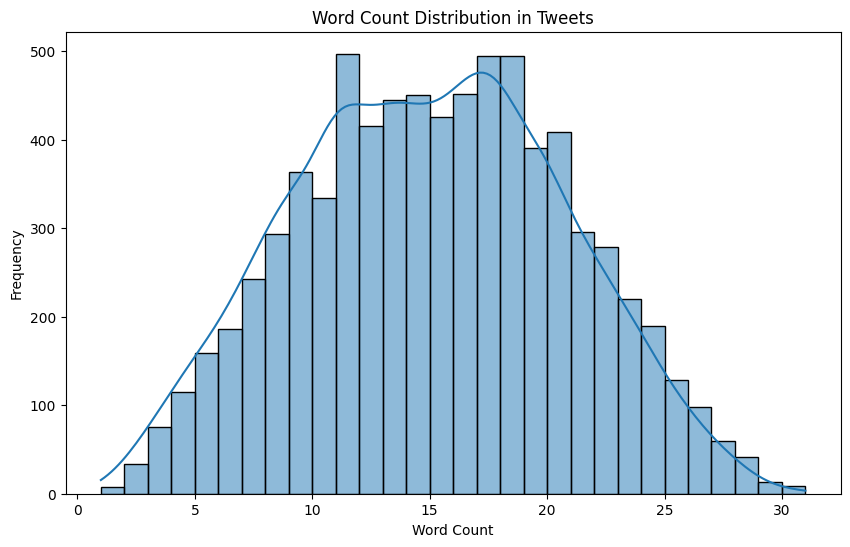

In [24]:
# Calculate word counts for each tweet
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=30, kde=True)
plt.title('Word Count Distribution in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


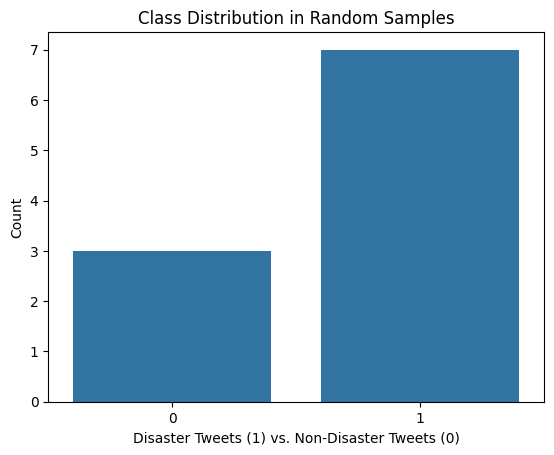

In [25]:
sns.countplot(x='target', data=random_samples)
plt.title('Class Distribution in Random Samples')
plt.xlabel('Disaster Tweets (1) vs. Non-Disaster Tweets (0)')
plt.ylabel('Count')
plt.show()


# Challenge

In [31]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Preprocessing
nltk.download('stopwords') # 'the', 'is', 'in', 'and'

def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'[^a-z\s]', '', text)
  stop_words = set(stopwords.words('english'))
  text = " ".join([word for word in text.split() if word not in stop_words])
  return text

train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text_clean'].astype(str))
max_features = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(train_df['text_clean'].astype(str))

X = pad_sequences(sequences, maxlen=25)
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Build, train, and compile model
from tensorflow.keras.layers import Bidirectional, LSTM

model_bidirectional_lstm = Sequential([
    Embedding(input_dim=max_features, output_dim=64),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(1, activation='sigmoid')
], name='Multiple_Bidirectional_LSTM_Model')

model_bidirectional_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_val, y_val))

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.5640 - loss: 0.6849 - val_accuracy: 0.5634 - val_loss: 0.6729
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6133 - loss: 0.6364 - val_accuracy: 0.7859 - val_loss: 0.4915
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.8639 - loss: 0.3576 - val_accuracy: 0.7814 - val_loss: 0.4843
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9187 - loss: 0.2372 - val_accuracy: 0.7774 - val_loss: 0.5280
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9515 - loss: 0.1600 - val_accuracy: 0.7722 - val_loss: 0.5664
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9628 - loss: 0.1315 - val_accuracy: 0.7695 - val_loss: 0.6577
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9714 - loss: 0.0993 - val_accuracy: 0.7676 - val_loss: 0.7362
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9770 - loss: 0.0823 - 

# LSTM Architecture
LSTM layers help models to both remember details from long ago and forget irrelevant data, perfect for complex tasks where the sequence and context of information (like the unfolding of a story) matter a lot.

In [34]:
# LSTM Architecture .summary()
model_bidirectional_lstm.summary()

Model: "Multiple_Bidirectional_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 25, 64)              │       1,072,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 25, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,323,813 (12.68 MB)

 Trainable params: 1,107,937 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,215,876 (8.45 MB)

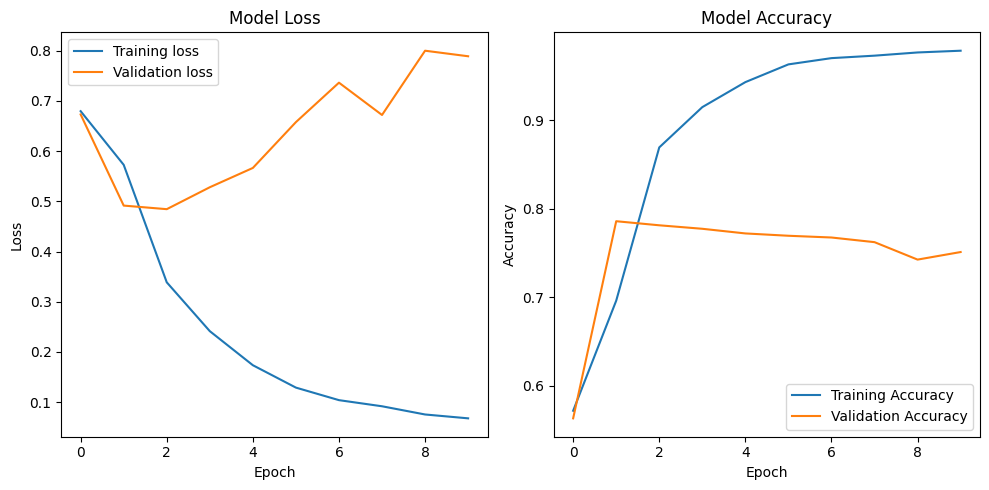

In [36]:
# After training, plot the loss and accuracy
plot_loss_and_accuracy(history_bidirectional_lstm) # pass in your model

# GRU model

A GRU layer helps the model remember and use past information to make decisions, making it great for tasks where understanding the sequence or flow of data (like the order of words in a sentence) is important.

In [ ]:
# GRU model



In [ ]:
# GRU Architecture


In [ ]:
# After training, plot the loss and accuracy
